In [1]:
import sys

sys.path.append("../")
from benchmarks.benchmark import get_num_latents
import jax 
import jax.numpy as jnp
import numpy as np

def benchmark_chains(model, sampler, key, n=10000, batch=None):

    pvmap = jax.pmap

    d = get_num_latents(model)
    if batch is None:
        batch = np.ceil(1000 / d).astype(int)
    key, init_key = jax.random.split(key, 2)
    keys = jax.random.split(key, batch)

    init_keys = jax.random.split(init_key, batch)
    init_pos = pvmap(model.sample_init)(init_keys)  # [batch_size, dim_model]

    params, grad_calls_per_traj, acceptance_rate, expectation, ess_corr = pvmap(
        lambda pos, key: sampler(
            model=model, num_steps=n, initial_position=pos, key=key
        )
    )(init_pos, keys)

    return jnp.mean(jnp.sqrt(expectation)[:, :, 0], axis=0)

In [2]:
from benchmarks.inference_models import StandardNormal
from benchmarks.sampling_algorithms import run_adjusted_mclmc_no_tuning, run_nuts, run_unadjusted_mclmc
import blackjax

model = StandardNormal(1000)
# model = Brownian()
integrator_type = "mclachlan"
num_steps = 5000
num_chains = 128
key1 = jax.random.PRNGKey(1)

init_key, state_key, run_key = jax.random.split(key1, 3)
initial_position = model.sample_init(init_key)
unadjusted_initial_state = blackjax.mcmc.mclmc.init(
    position=initial_position, logdensity_fn=model.logdensity_fn, rng_key=state_key
)
adjusted_initial_state = blackjax.mcmc.adjusted_mclmc.init(
    position=initial_position,
    logdensity_fn=model.logdensity_fn,
    random_generator_arg=state_key,
    )

results_mclmc = benchmark_chains(
            model,
            run_unadjusted_mclmc(integrator_type=integrator_type, preconditioning=False),
            key1,
            n=num_steps,
            batch=num_chains,
        )

results_nuts = benchmark_chains(
            model,
            run_nuts(integrator_type="velocity_verlet", preconditioning=False),
            key1,
            n=num_steps,
            batch=num_chains,
        )


In [3]:
results_mclmc

Array([-0.01467559, -0.01665149, -0.01586755, ..., -0.0149228 ,
       -0.01492377, -0.01492339], dtype=float32)

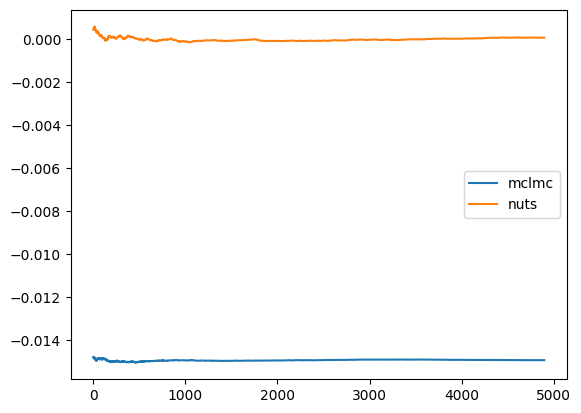

In [4]:
# plot results

import matplotlib.pyplot as plt
plt.plot(results_mclmc[100:], label="mclmc")
plt.plot(results_nuts[100:], label="nuts")
plt.legend()
plt.show()